"query.bed" was too large to be included in the repo.

In [1]:
import matplotlib.pyplot as plt

In [ ]:
#Read file and calculate fragment lengths
fragment_lengths = []

with open('query.bed', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 3:
            start = int(parts[1])
            end = int(parts[2])
            length = end - start
            if length > 0:
                fragment_lengths.append(length)


In [ ]:
#Count frequencies using a dictionary
length_counts = {}
for length in fragment_lengths:
    if length in length_counts:
        length_counts[length] += 1
    else:
        length_counts[length] = 1


In [ ]:
#Normalize
total = sum(length_counts.values())
normalized_counts = {length: count / total for length, count in length_counts.items()}


In [ ]:
#Sort for plotting
sorted_lengths = sorted(normalized_counts.items())
x_vals = [length for length, _ in sorted_lengths]
y_vals = [freq for _, freq in sorted_lengths]


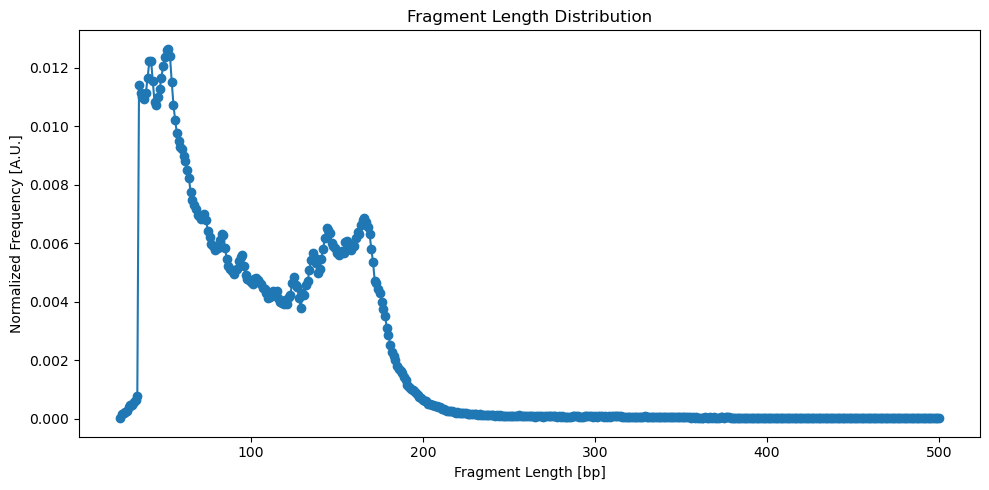

In [ ]:
#Plot
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution")
# plt.grid(True)
plt.tight_layout()
plt.show()

To get a good overall picture of the trends- we can smooth the curve using gaussian filter. 

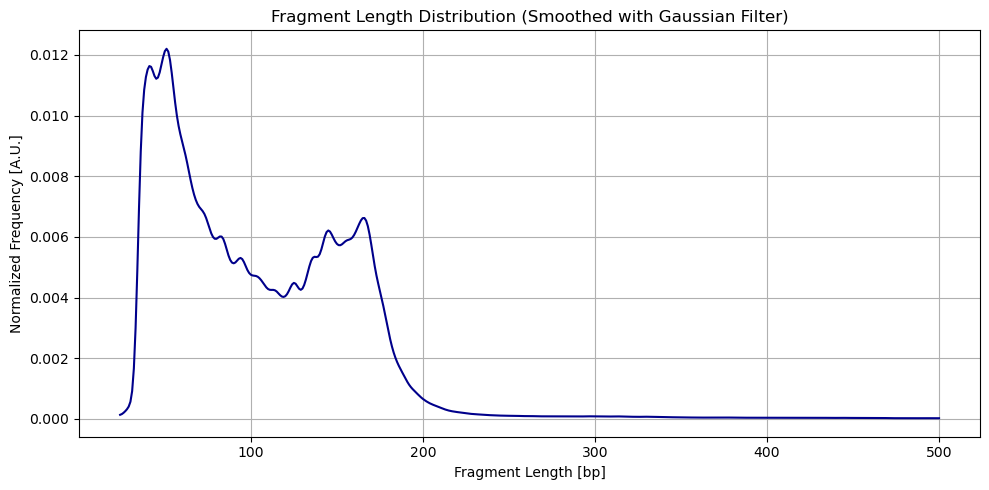

In [ ]:
#smoothen
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Step 1: Get sorted fragment lengths and frequencies
sorted_items = sorted(length_counts.items())
x_vals = np.array([length for length, _ in sorted_items])
y_vals_raw = np.array([count for _, count in sorted_items])

# Step 2: Normalize frequencies
y_vals = y_vals_raw / y_vals_raw.sum()

# Step 3: Apply Gaussian smoothing
sigma = 2  #the main parameter
y_smooth = gaussian_filter1d(y_vals, sigma=sigma)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_smooth, color='darkblue')
plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution (Smoothed with Gaussian Filter)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Rescaling


Read and Parse reference.hist

In [20]:
reference_hist = {}

with open("reference.hist") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        length = int(parts[0])
        freq = float(parts[1])
        reference_hist[length] = freq


Compute Query Fragment Lengths

In [21]:
from collections import defaultdict

# Group fragments by length
fragments_by_length = defaultdict(list)

with open("query.bed") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 3:
            continue
        start = int(parts[1])
        end = int(parts[2])
        length = end - start
        fragments_by_length[length].append(line)


Subsample Query to Match Reference Histogram

In [22]:
import random

# Total number of query fragments
total_query_fragments = sum(len(v) for v in fragments_by_length.values())

# Target number of fragments to sample: same total size
rescaled_total = total_query_fragments

# Dictionary of rescaled fragments
rescaled_fragments = []

for length, ref_freq in reference_hist.items():
    if length in fragments_by_length:
        available = fragments_by_length[length]
        sample_size = min(len(available), int(ref_freq * rescaled_total))
        rescaled_fragments.extend(random.sample(available, sample_size))


Plot Comparison of Distributions

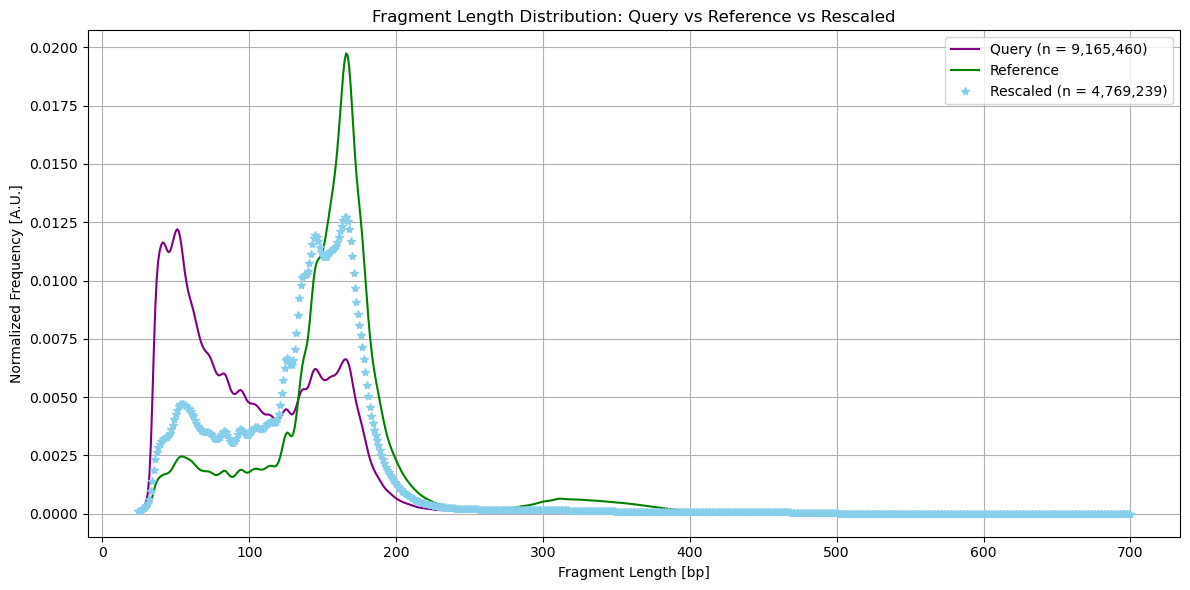

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.ndimage import gaussian_filter1d

# Raw query length distribution
query_lengths = []
for length, group in fragments_by_length.items():
    query_lengths.extend([length] * len(group))

# Rescaled lengths
rescaled_lengths = [int(line.strip().split()[2]) - int(line.strip().split()[1]) for line in rescaled_fragments]

# Count and normalize
def normalize_counts(lengths):
    counts = Counter(lengths)
    total = sum(counts.values())
    norm = {k: v / total for k, v in counts.items()}
    return norm

query_norm = normalize_counts(query_lengths)
rescaled_norm = normalize_counts(rescaled_lengths)
reference_norm = reference_hist  # already normalized

# Sort all keys
all_lengths = sorted(set(query_norm) | set(rescaled_norm) | set(reference_norm))

# Prepare aligned arrays
def aligned_y(norm_dict):
    return np.array([norm_dict.get(l, 0) for l in all_lengths])

y_query = aligned_y(query_norm)
y_rescaled = aligned_y(rescaled_norm)
y_reference = aligned_y(reference_norm)

# Optional smoothing
sigma = 2
y_query_smooth = gaussian_filter1d(y_query, sigma)
y_rescaled_smooth = gaussian_filter1d(y_rescaled, sigma)
y_reference_smooth = gaussian_filter1d(y_reference, sigma)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(all_lengths, y_query_smooth, label=f"Query (n = {len(query_lengths):,})", color="purple")
plt.plot(all_lengths, y_reference_smooth, label="Reference", color="green")
plt.plot(all_lengths, y_rescaled_smooth, label=f"Rescaled (n = {len(rescaled_lengths):,})", marker="*", linestyle='None', color="skyblue")

plt.xlabel("Fragment Length [bp]")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution: Query vs Reference vs Rescaled")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
